# Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score

import warnings
warnings.filterwarnings('ignore')

# Data

In [2]:
df = pd.read_csv('data/large_train_sample.csv')
print(df.shape)
df.head()

(32561, 14)


age          workclass  fnlwgt   education  education-num  \
0   39          State-gov   77516   Bachelors             13   
1   50   Self-emp-not-inc   83311   Bachelors             13   
2   38            Private  215646     HS-grad              9   
3   53            Private  234721        11th              7   
4   28            Private  338409   Bachelors             13   

        marital-status          occupation    relationship      sex  \
0        Never-married        Adm-clerical   Not-in-family     Male   
1   Married-civ-spouse     Exec-managerial         Husband     Male   
2             Divorced   Handlers-cleaners   Not-in-family     Male   
3   Married-civ-spouse   Handlers-cleaners         Husband     Male   
4   Married-civ-spouse      Prof-specialty            Wife   Female   

   capital-gain  capital-loss  hours-per-week  native-country    wage  
0          2174             0              40   United-States   <=50K  
1             0             0              13   United-States   <=50K  
2             0             0              40   United-States   <=50K  
3             0             0              40   United-States   <=50K  
4             0             0              40            Cuba   <=50K

# Data Cleaning

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   sex             32561 non-null  object
 9   capital-gain    32561 non-null  int64 
 10  capital-loss    32561 non-null  int64 
 11  hours-per-week  32561 non-null  int64 
 12  native-country  32561 non-null  object
 13  wage            32561 non-null  object
dtypes: int64(6), object(8)
memory usage: 3.5+ MB


Drop columns we don't need

In [4]:
drop_lis =['fnlwgt', 'education', 'marital-status', 'occupation']
df.drop(drop_lis, axis = 1, inplace = True)

In [5]:
df = df.drop(df.index[df.workclass == ' ?'])

Binarize wage, sex, native country column

In [6]:
df.wage.unique()

array([' <=50K', ' >50K'], dtype=object)

In [7]:
df['wage'] = df.wage.map({' >50K':0, ' <=50K':1})

df['sex']= df.sex.map({' Male':0, ' Female':1})

In [8]:
us_mask = df['native-country'] == ' United-States'
df.loc[~us_mask, 'native-country'] = 0
df.loc[us_mask, 'native-country'] = 1

df['native-country'] = df['native-country'].astype(int)

Dummy relationship and workclass columns

In [9]:
df = pd.get_dummies(df, columns = ['relationship', 'workclass'])

drop 2 unneeded dummy columns

In [10]:
df.drop('workclass_ Never-worked', axis = 1, inplace = True)
df.drop('relationship_ Not-in-family', axis = 1, inplace = True)

## Summary Stats

In [11]:
df.describe()

age  education-num           sex  capital-gain  capital-loss  \
count  30725.000000   30725.000000  30725.000000  30725.000000  30725.000000   
mean      38.439512      10.129699      0.323255   1105.785094     88.889959   
std       13.119665       2.562702      0.467727   7497.027762    405.613208   
min       17.000000       1.000000      0.000000      0.000000      0.000000   
25%       28.000000       9.000000      0.000000      0.000000      0.000000   
50%       37.000000      10.000000      0.000000      0.000000      0.000000   
75%       47.000000      13.000000      1.000000      0.000000      0.000000   
max       90.000000      16.000000      1.000000  99999.000000   4356.000000   

       hours-per-week  native-country          wage  relationship_ Husband  \
count    30725.000000    30725.000000  30725.000000           30725.000000   
mean        40.946461        0.895395      0.751017               0.413474   
std         11.987385        0.306049      0.432431               0.492464   
min          1.000000        0.000000      0.000000               0.000000   
25%         40.000000        1.000000      1.000000               0.000000   
50%         40.000000        1.000000      1.000000               0.000000   
75%         45.000000        1.000000      1.000000               1.000000   
max         99.000000        1.000000      1.000000               1.000000   

       relationship_ Other-relative  relationship_ Own-child  \
count                  30725.000000             30725.000000   
mean                       0.029878                 0.147437   
std                        0.170253                 0.354547   
min                        0.000000                 0.000000   
25%                        0.000000                 0.000000   
50%                        0.000000                 0.000000   
75%                        0.000000                 0.000000   
max                        1.000000                 1.000000   

       relationship_ Unmarried  relationship_ Wife  workclass_ Federal-gov  \
count             30725.000000        30725.000000            30725.000000   
mean                  0.106461            0.046737                0.031245   
std                   0.308431            0.211079                0.173982   
min                   0.000000            0.000000                0.000000   
25%                   0.000000            0.000000                0.000000   
50%                   0.000000            0.000000                0.000000   
75%                   0.000000            0.000000                0.000000   
max                   1.000000            1.000000                1.000000   

       workclass_ Local-gov  workclass_ Private  workclass_ Self-emp-inc  \
count          30725.000000        30725.000000             30725.000000   
mean               0.068120            0.738682                 0.036322   
std                0.251957            0.439360                 0.187094   
min                0.000000            0.000000                 0.000000   
25%                0.000000            0.000000                 0.000000   
50%                0.000000            1.000000                 0.000000   
75%                0.000000            1.000000                 0.000000   
max                1.000000            1.000000                 1.000000   

       workclass_ Self-emp-not-inc  workclass_ State-gov  \
count                 30725.000000          30725.000000   
mean                      0.082701              0.042246   
std                       0.275435              0.201153   
min                       0.000000              0.000000   
25%                       0.000000              0.000000   
50%                       0.000000              0.000000   
75%                       0.000000              0.000000   
max                       1.000000              1.000000   

       workclass_ Without-pay  
count            30725.000000  
mean                 0

## EDA

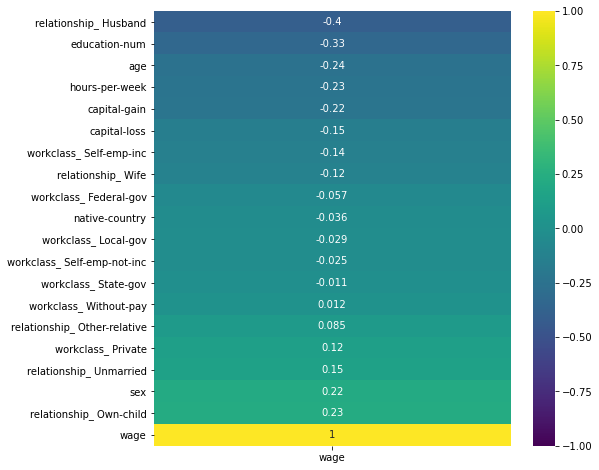

In [12]:
plt.figure(figsize = (8,8))
sns_plot = sns.heatmap(df.corr()[['wage']].sort_values('wage'),
           annot=True,
           cmap='viridis',
           vmin=-1,
           vmax=1)
fig = sns_plot.get_figure()

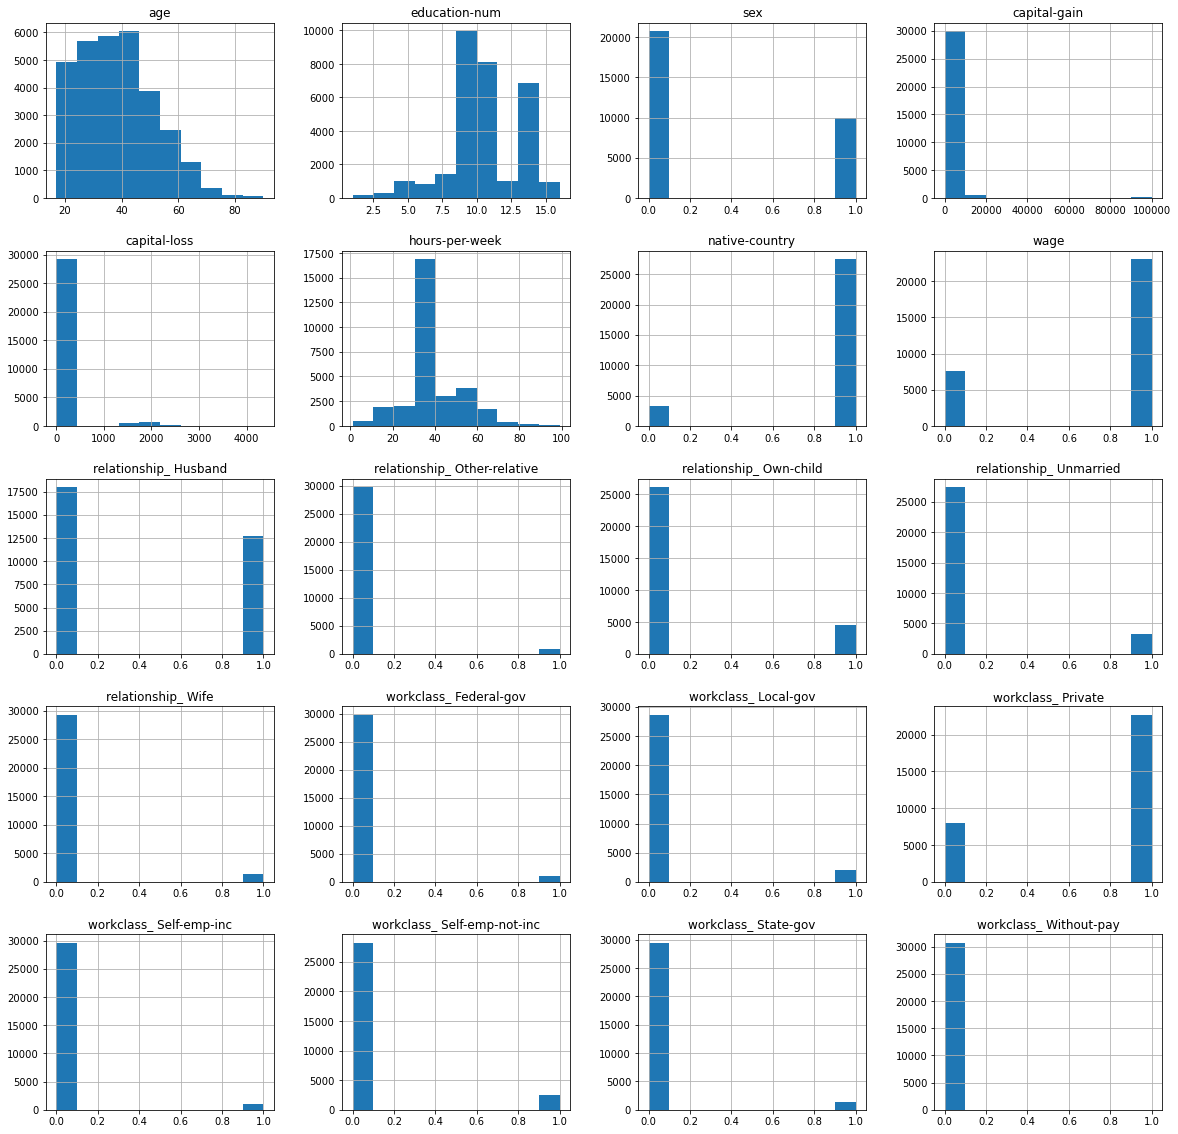

In [13]:
df.hist(figsize=(20, 20));

# Modeling

In [14]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['wage'], axis =1), 
                                                    df['wage'], 
                                                    random_state = 6)

## Random Forest

In [15]:
params = {
    'max_depth': [1, 2, 3, 4, 6, 8],
    'min_samples_leaf': [2, 3],
    'n_estimators': [25, 75],
    'n_jobs': [-1]}
    
gs = GridSearchCV(RandomForestClassifier(random_state = 6),
                  param_grid = params)
gs.fit(X_train, y_train)
print(gs.best_score_)
gs.best_params_

0.8519285278953015


{'max_depth': 8, 'min_samples_leaf': 3, 'n_estimators': 75, 'n_jobs': -1}

### Cross Val Scores

In [16]:
params = gs.best_params_
scores = cross_val_score(gs, 
                         X_train, y_train,
                         cv = 5,
                         n_jobs = -1)

print(f'Score on training set: {gs.score(X_train, y_train)}')
print(f'Score on testing set: {gs.score(X_test, y_test)}')
print('Accuracy: {:.4f} ± {:.4f}'.format(scores.mean(), 
                                 2 * scores.std()))

Score on training set: 0.8553573753417524
Score on testing set: 0.8499088778963811
Accuracy: 0.8516 ± 0.0114


**Evaluation:** The model displays good accuracy scores for both test and train data, numbers closer to 1.
The accuracy score is slightly lower for the test data compared to the train data indicating an overfit of the model. This is typically expected with RF models..best_params_
scores = cross_val_score. When compared to the UCI repository, the original site of the data, our model, with feature constraints performed as expected.

### Confusion Matrix - Random Forest

Accuracy: 0.8499088778963811
Sensitivity: 0.9590602867507342
Precision: 0.8583797155225726
Recall: 0.9590602867507342
F1: 0.9059313045606592
Cross val score: 0.8519285278953015


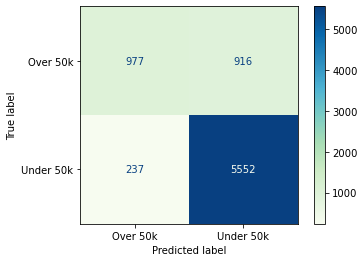

In [17]:
rf_pred = gs.predict(X_test)
metrics.confusion_matrix(y_test, rf_pred)
metrics.plot_confusion_matrix(gs, X_test, y_test, cmap = 'GnBu', display_labels=['Over 50k', 'Under 50k']);

print('Accuracy:', gs.score(X_test, y_test))
print('Sensitivity:', metrics.recall_score(y_test, rf_pred))
print('Precision:', metrics.precision_score(y_test, rf_pred))
print('Recall:', metrics.recall_score(y_test, rf_pred))
print('F1:', metrics.f1_score(y_test, rf_pred))
print('Cross val score:', (gs.best_score_))

## XGBClassifier

In [18]:
params_2 = {
    'max_depth': [1, 2, 3, 4, 6, 8],
    'verbosity': [0],
    'eta': [.1, .2, .4],
    'n_estimators': [25, 75],
    'n_jobs': [-1]
}
    
gs_2 = GridSearchCV(XGBClassifier(random_state = 6), 
                    param_grid = params_2)
gs_2.fit(X_train, y_train)
print(gs_2.best_score_)
gs_2.best_params_

0.8638193822924954


{'eta': 0.4, 'max_depth': 3, 'n_estimators': 75, 'n_jobs': -1, 'verbosity': 0}

### Cross Val Scores

In [19]:
params_2 = gs_2.best_params_
scores_2 = cross_val_score(gs_2, 
                           X_train, y_train, 
                           cv = 5, 
                           n_jobs = -1)

print(f'Score on training set: {gs_2.score(X_train, y_train)}')
print(f'Score on testing set: {gs_2.score(X_test, y_test)}')
print('Accuracy: {:.4f} ± {:.4f}'.format(scores_2.mean(), 
                                 2 * scores_2.std()))

Score on training set: 0.8699388100507747
Score on testing set: 0.8605831814631606
Accuracy: 0.8623 ± 0.0099


**Evaluation:** The model displays good accuracy scores for both test and train data, with the test data outperforming the train data.

### Confusion Matrix - XGBClassifier

Accuracy: 0.8605831814631606
Sensitivity: 0.9419588875453446
Precision: 0.8812217194570136
Recall: 0.9419588875453446
F1: 0.9105786090005844
Cross val score: 0.8638193822924954


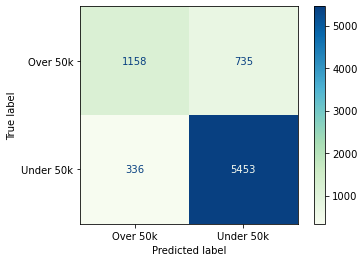

In [20]:
xg_pred = gs_2.predict(X_test)
metrics.confusion_matrix(y_test, xg_pred)
metrics.plot_confusion_matrix(gs_2, X_test, y_test, cmap = 'GnBu', display_labels=['Over 50k', 'Under 50k']);

print('Accuracy:', gs_2.score(X_test, y_test))
print('Sensitivity:', metrics.recall_score(y_test, xg_pred))
print('Precision:', metrics.precision_score(y_test, xg_pred))
print('Recall:', metrics.recall_score(y_test, xg_pred))
print('F1:', metrics.f1_score(y_test, xg_pred))
print('Cross val score:', (gs_2.best_score_))

## XGBClassifier Dart

In [21]:
params_3 = {
    'booster' : ['dart'],
    'verbosity' : [0],
    'use_label_encoder' : [False],
    'sample_type' : ['uniform', 'weighted'],
    'normalize_type' : ['tree', 'forest'],
    'rate_drop' : [0, .1,],
    'one_drop' : [0, 1],
    'n_jobs' : [-1]
}

gs_3 = GridSearchCV(XGBClassifier(random_state = 6), param_grid = params_3)
gs_3.fit(X_train, y_train)
print(gs_3.best_score_)
gs_3.best_params_

0.8621269847189075


{'booster': 'dart',
 'n_jobs': -1,
 'normalize_type': 'tree',
 'one_drop': 0,
 'rate_drop': 0,
 'sample_type': 'uniform',
 'use_label_encoder': False,
 'verbosity': 0}

### Cross Val Scores

In [22]:
params_3 = gs_3.best_params_
scores_3 = cross_val_score(gs_3, 
                           X_train, y_train, 
                           cv = 5, 
                           n_jobs = -1)

print(f'Score on training set: {gs_3.score(X_train, y_train)}')
print(f'Score on testing set: {gs_3.score(X_test, y_test)}')
print('Accuracy: {:.4f} ± {:.4f}'.format(scores_2.mean(), 
                                 2 * scores.std()))

Score on training set: 0.8855617758104414
Score on testing set: 0.8624056235355376
Accuracy: 0.8623 ± 0.0114


**Evaluation:** stuff & things

### Confusion Matrix - XGBClassifier Dart

Accuracy: 0.8624056235355376
Sensitivity: 0.9364311625496632
Precision: 0.8872340425531915
Recall: 0.9364311625496632
F1: 0.9111690057988066
Cross val score: 0.8621269847189075


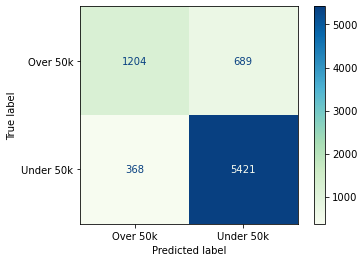

In [23]:
dart_preds = gs_3.predict(X_test)
metrics.confusion_matrix(y_test, dart_preds)
metrics.plot_confusion_matrix(gs_3, X_test, y_test, cmap = 'GnBu', display_labels=['Over 50k', 'Under 50k']);

print('Accuracy:', gs_3.score(X_test, y_test))
print('Sensitivity:', metrics.recall_score(y_test, dart_preds))
print('Precision:', metrics.precision_score(y_test, dart_preds))
print('Recall:', metrics.recall_score(y_test, dart_preds))
print('F1:', metrics.f1_score(y_test, dart_preds))
print('Cross val score:', (gs_3.best_score_))

# Export Data

In [24]:
x_sub = pd.read_csv('./data/test_data.csv')

drop_lis =['fnlwgt', 'education', 'marital-status', 'occupation']
x_sub.drop(drop_lis, axis=1, inplace= True)

x_sub ['sex']= x_sub.sex.map({' Female': 1, ' Male':0})

us_mask = x_sub['native-country'] == ' United-States'
x_sub.loc[~us_mask, 'native-country'] = 0
x_sub.loc[us_mask, 'native-country'] = 1
x_sub['native-country'] = x_sub['native-country'].astype(int)

x_sub = x_sub.drop(x_sub.index[x_sub.workclass == ' ?'])

x_sub = pd.get_dummies(x_sub, columns=['relationship','workclass'],)

x_sub.drop('workclass_ Never-worked', axis = 1, inplace = True)
x_sub.drop('relationship_ Not-in-family', axis = 1, inplace = True)

In [25]:
wage_sub = gs_2.predict(x_sub)
sf = pd.DataFrame(wage_sub, columns = ['wage'])
sf.to_csv('./data/sub.csv')